In [1]:
pip install yfinance

In [2]:
pip install ta

# Obtención de datos

In [3]:
import yfinance as yf
import pandas as pd
import ta
import time

def datos_historicos(ticker):
    # Descargar datos históricos
    datos = yf.download(ticker, start="2010-01-01", end="2024-08-27")

    # Convertir el índice a fecha sin hora
    datos.index = pd.to_datetime(datos.index).date

    # Calcular indicadores técnicos (comentados por ahora)
    '''
    datos['SMA50'] = ta.trend.sma_indicator(datos['Close'], window=50)
    datos['SMA200'] = ta.trend.sma_indicator(datos['Close'], window=200)
    datos['MACD'] = ta.trend.macd(datos['Close'])
    datos['MACD_Signal'] = ta.trend.macd_signal(datos['Close'])
    datos['MACD_Hist'] = ta.trend.macd_diff(datos['Close'])
    datos['RSI'] = ta.momentum.rsi(datos['Close'], window=14)'''

    # Seleccionar columnas relevantes
    datos = datos[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']]  # 'SMA50', 'SMA200', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI'

    # Bucle para actualizar datos cada 60 segundos (si es necesario)
    while True:
        new_data = yf.download(ticker, period='1d', interval='5m')
        new_data.index = pd.to_datetime(new_data.index).date  # Convertir el índice a fecha sin hora
        data = pd.concat([datos, new_data]).drop_duplicates()
        time.sleep(60)
        return data

# Ticker
ticker = 'SPY'
datos_SP500 = datos_historicos(ticker)

# Guardar a CSV
datos_SP500.index.name = 'Date'
datos_SP500.to_csv(f'{ticker}_datos_historicos.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
datos_SP500

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,118944600,86.580750
2010-01-05,113.260002,113.680000,112.849998,113.629997,111579900,86.809944
2010-01-06,113.519997,113.989998,113.430000,113.709999,116074400,86.871048
2010-01-07,113.500000,114.330002,113.180000,114.190002,131091100,87.237755
2010-01-08,113.889999,114.620003,113.660004,114.570000,126402800,87.528053
...,...,...,...,...,...,...
2024-09-17,562.580017,562.770020,562.539978,562.690002,100110,562.690002
2024-09-17,562.669983,562.889893,562.530029,562.719971,217931,562.719971
2024-09-17,562.690002,562.770020,561.330017,561.770325,723392,561.770325


In [5]:
datos_SP500.corr()

,Open,High,Low,Close,Volume,Adj Close
Open,1.000000,0.999916,0.999891,0.999821,-0.538926,0.999279
High,0.999916,1.000000,0.999816,0.999883,-0.535425,0.999397
Low,0.999891,0.999816,1.000000,0.999899,-0.544242,0.999300
Close,0.999821,0.999883,0.999899,1.000000,-0.540564,0.999447
Volume,-0.538926,-0.535425,-0.544242,-0.540564,1.000000,-0.529179
Adj Close,0.999279,0.999397,0.999300,0.999447,-0.529179,1.000000


In [6]:
print(datos_SP500.isnull().sum())

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64


In [7]:
# Eliminando múltiples columnas
datos_close = datos_SP500.drop(['Open', 'High','Low','Volume','Adj Close'], axis=1)
datos_close

,Close
Date,
2010-01-04,113.330002
2010-01-05,113.629997
2010-01-06,113.709999
2010-01-07,114.190002
2010-01-08,114.570000
...,...
2024-09-17,562.690002
2024-09-17,562.719971
2024-09-17,561.770325


In [8]:
#datos_close.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

#LSTM

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [10]:

# Normalizamos la data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(datos_close)

# Dividir los datos en conjuntos de train y prueba.
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]



In [11]:
def create_sequences(datos_close, seq_length):
    X, y = [], []
    for i in range(len(datos_close) - seq_length):
        X.append(datos_close[i:i+seq_length])
        y.append(datos_close[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 400  # Número de pasos de tiempo para mirar atrás
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [12]:
from keras import callbacks
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler


In [13]:
# Construir la red neuronal LSTM
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Predecimos un único valor: el precio ajustado
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - loss: 0.0153 - val_loss: 9.1265e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 4.7989e-04 - val_loss: 6.7539e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 4.5677e-04 - val_loss: 7.1934e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 3.1073e-04 - val_loss: 6.3470e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 3.5137e-04 - val_loss: 9.8800e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 2.4265e-04 - val_loss: 0.0018
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - loss: 2.0608e-04 - val_loss: 0.0026
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 2.2511e-04 - val_loss: 0.0024
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 1.8375e-04 - val_loss: 0.0034
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 1.9748e-04 - val_loss: 0.0028
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 1.3705e-04 - val_loss: 0.0

In [14]:
import matplotlib.pyplot as plt

70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


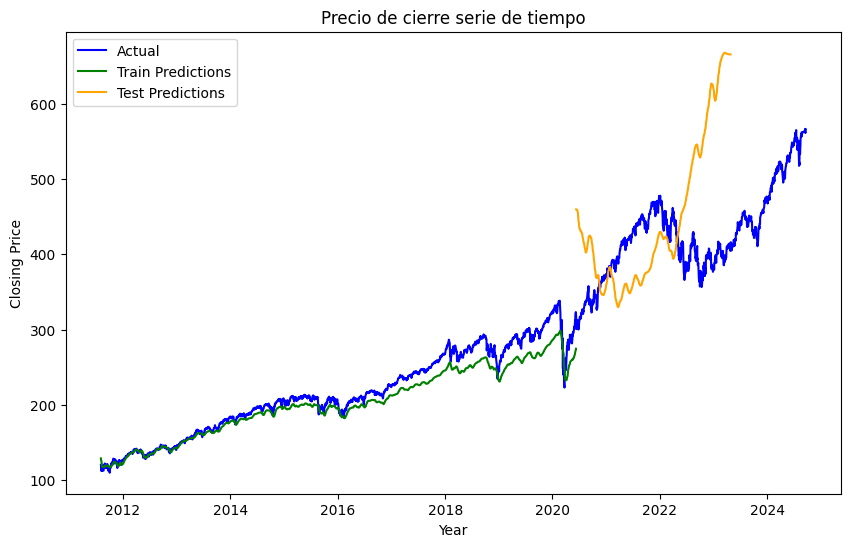

In [15]:
# Predecir usando el modelo entrenado
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Transformación inversa de las predicciones
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Convertir índice de datos_close a datetime si no lo está
if not pd.api.types.is_datetime64_any_dtype(datos_close.index):
    datos_close.index = pd.to_datetime(datos_close.index)

# Ajustar el índice de las predicciones
train_index = datos_close.index[seq_length:seq_length+len(train_predictions)]
test_index = datos_close.index[seq_length+len(train_predictions):seq_length+len(train_predictions)+len(test_predictions)]

# Plot predicciones
plt.figure(figsize=(10, 6))

# Plot data actual
plt.plot(datos_close.index[seq_length:], datos_close['Close'][seq_length:], label='Actual', color='blue')

# Plot predicciones de entramiento
plt.plot(train_index, train_predictions, label='Train Predictions', color='green')

# Plot predicciones de prueba
plt.plot(test_index, test_predictions, label='Test Predictions', color='orange')

plt.title('Precio de cierre serie de tiempo')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


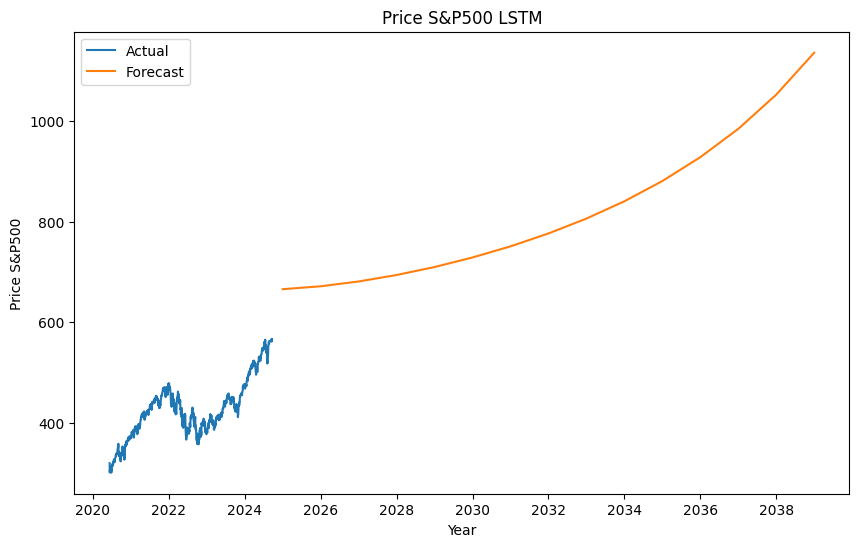

In [16]:
#Prediccion del S&P500
forecast_period = 15
forecast = []

# Utilice la última secuencia de los datos de prueba para hacer predicciones
last_sequence = X_test[-1]

for _ in range(forecast_period):
    # Remodelar la secuencia para que coincida con la forma de entrada del modelo
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    # Predecir el siguiente valor
    next_prediction = model.predict(current_sequence)[0][0]
    # Agregar la predicción a la lista de pronósticos
    forecast.append(next_prediction)
    # Actualice la última secuencia eliminando el primer elemento y agregando el valor previsto
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Transformación inversa de los valores pronosticados.
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Convertir el índice de datos de prueba a fecha y hora si aún no lo está
if not pd.api.types.is_datetime64_any_dtype(datos_close.index):
    datos_close.index = pd.to_datetime(datos_close.index)

# Plot de los valores pronosticados
plt.figure(figsize=(10, 6))
plt.plot(datos_close.index[-len(test_data):], scaler.inverse_transform(test_data), label='Actual')

# Frecuencia diaria para el rango de fechas
forecast_dates = pd.date_range(start=datos_close.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='Y')
plt.plot(forecast_dates, forecast, label='Forecast')

plt.title('Price S&P500 LSTM')
plt.xlabel('Year')
plt.ylabel('Price S&P500')
plt.legend()
plt.show()
plt.show()

In [17]:
#Predicciones en formato Tabular
forecast_final = np.ravel(forecast)
df_final = pd.DataFrame({"Date ": forecast_dates,'Close': forecast_final})
df_final

,Date,Close
0,2024-12-31,665.322205
1,2025-12-31,671.112305
2,2026-12-31,680.659790
3,2027-12-31,693.507324
4,2028-12-31,709.432861
5,2029-12-31,728.395569
6,2030-12-31,750.537903
7,2031-12-31,776.183838
8,2032-12-31,805.851257
9,2033-12-31,840.286682


In [18]:
# Guardar el DataFrame como un archivo CSV
df_final.to_csv('predicciones_Close_S&P500.csv')